In [ ]:
!pip install sastrawi
!pip install indoNLP
!pip install transformers torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 1.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manyl

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import nltk
from nltk.corpus import stopwords
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from wordcloud import WordCloud, STOPWORDS
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.tokenize import word_tokenize
from indoNLP.preprocessing import replace_slang, replace_word_elongation, remove_html
import pandas as pd
from collections import Counter
import re

In [ ]:
train = pd.read_excel('/content/dataset_penyisihan_bdc_2024.xlsx')
train

,text,label
0,Kunjungan Prabowo ini untuk meresmikan dan men...,Sumber Daya Alam
1,RT Anies dapat tepuk tangan meriah saat jadi R...,Politik
2,@CIqXqwGAT04tMtx4OCATxjoVq7vv/Y8HeYaIOgMFg8Y= ...,Demografi
3,RT @L3R8XFBw3WGbxRPSj0/0hHZTbqVGX7qtfwRg9zmhK7...,Politik
4,Anies Baswedan Harap ASN termasuk TNI dan Polr...,Politik
...,...,...
4995,RT @l1DsGGe2xObT3t72dHwqlT58X7jvEYtEnauZIZSYwS...,Politik
4996,Masyarakat yakin bahwa Prabowo-Gibran memiliki...,Politik
4997,imo both are irrational but yg satu jauh lebih...,Ekonomi
4998,@cIIGSdjaPrmAQY1E4gWnLpIZSdyQn8ZMhjJzgOsxfRM= ...,Pertahanan dan Keamanan


In [ ]:
test = pd.read_excel('/content/dataset_unlabeled_penyisihan_bdc_2024.xlsx')
test

,IDText,Text
0,TXT0001,Lu mau org2 pro-demokrasi di negara ini bisa p...
1,TXT0002,Prabowo ditanya soal hutang luar negeri dia me...
2,TXT0003,kiki_daliyo Ganjar Pranowo itulah beliau soso...
3,TXT0004,@kumparan Prabowo Gibran yang bisa melakukan i...
4,TXT0005,@sniperruben45 @uda_zulhendra @ainunnajib Lah ...
...,...,...
995,TXT0996,"Bikin bangga deh, Ganjar-Mahfud mau alokasikan..."
996,TXT0997,Pak Jokowi sebelum pilpres 2024 berbesar hati ...
997,TXT0998,@datuakrajoangek Sbaiknya si gemot nga usah ik...
998,TXT0999,kebiasaan merembuk atau bermusyawarah jadi gay...


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5000 non-null   object
 1   label   5000 non-null   object
dtypes: object(2)
memory usage: 78.2+ KB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   IDText  1000 non-null   object
 1   Text    1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB


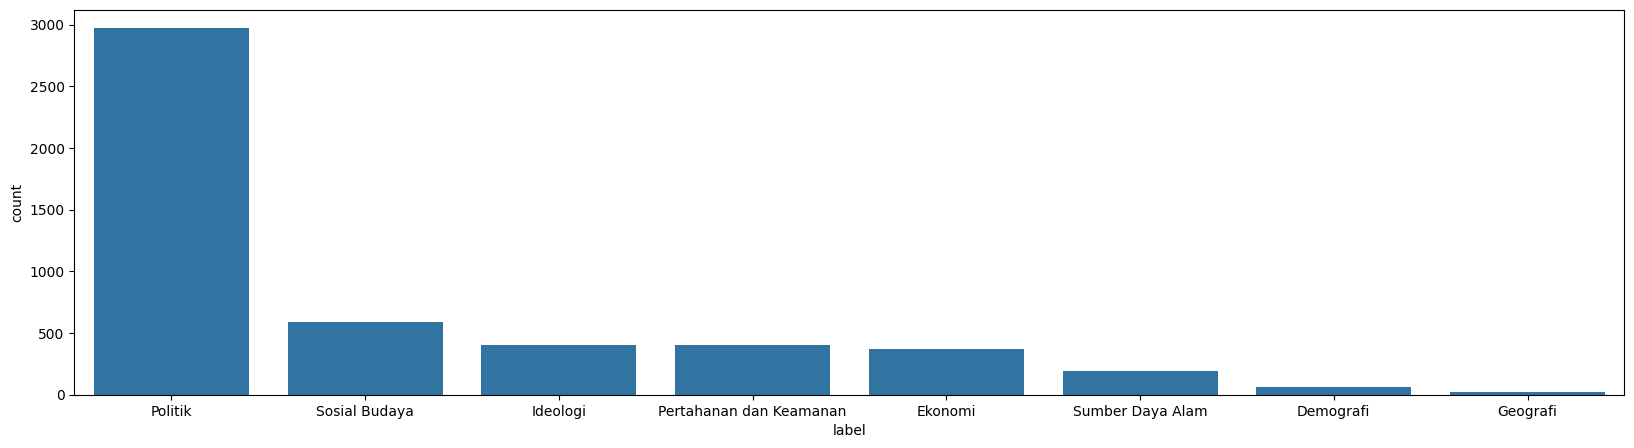

In [ ]:
plt.figure(figsize=(20,5))
target = train['label'].value_counts()
sns.barplot(x=target.index, y=target)
plt.show()

In [ ]:
target

label
Politik                    2972
Sosial Budaya               587
Ideologi                    400
Pertahanan dan Keamanan     400
Ekonomi                     367
Sumber Daya Alam            192
Demografi                    62
Geografi                     20
Name: count, dtype: int64

# Preprocess part 1

In [ ]:
# Download resources
nltk.download('stopwords')
nltk.download('punkt')

# Fungsi membersihkan email
def cleaning_email(data):
    return re.sub(r'@[^\s]+', ' ', data)

# Fungsi membersihkan URL
def cleaning_URLs(data):
    return re.sub(r'((www\.[^\s]+)|(https?://[^\s]+))', ' ', data)

# Fungsi membersihkan tanda baca
def cleaning_punctuations(text):
    return text.translate(str.maketrans('', '', string.punctuation))

# Fungsi membersihkan angka
def cleaning_numbers(data):
    return re.sub(r'[0-9]+', '', data)

# Fungsi menghapus karakter non-alfabet
def cleaning_non_alpha(text):
    return re.sub(r'[^a-z\s]', ' ', text)

# Lowercasing
def to_lowercase(data):
    return data.lower()

# Mengganti singkatan umum dalam bahasa Indonesia
def replace_slang(text):
    slang_dict = {
        "yg": "yang",
        "gak": "tidak",
        "nggak": "tidak",
        "kalo": "kalau",
        "mau": "ingin",
        # Tambahkan lebih banyak singkatan dan penggantinya sesuai kebutuhan
    }
    words = text.split()
    replaced_text = ' '.join([slang_dict[word] if word in slang_dict else word for word in words])
    return replaced_text

# Menggabungkan semua langkah preprocessing
def preprocess_text(text):
    text = to_lowercase(text)
    text = replace_slang(text)
    text = cleaning_email(text)
    text = cleaning_URLs(text)
    text = cleaning_punctuations(text)
    text = cleaning_numbers(text)
    text = cleaning_non_alpha(text)
    return text

# Terapkan preprocessing dasar ke setiap baris dalam kolom 'text'
train['text'] = train['text'].apply(preprocess_text)

# Dapatkan daftar stopwords bahasa Indonesia
stopwords_indonesia = stopwords.words('indonesian')
factory = StopWordRemoverFactory()
stopwords_sastrawi = factory.get_stop_words()
all_stopwords = set(stopwords_indonesia).union(set(stopwords_sastrawi))

# Buat stemmer untuk bahasa Indonesia
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Fungsi untuk membersihkan teks lebih lanjut
def final_clean_text(text):
    # Tokenisasi teks
    kata = word_tokenize(text)

    # Hapus stopwords
    #kata_tanpa_stopwords = [word for word in kata if not word in all_stopwords]

    # Stem kata
    kata_stemmed = [stemmer.stem(word) for word in kata]

    # Hapus kata-kata yang terlalu pendek (misal: satu huruf)
    kata_final = [word for word in kata_stemmed if len(word) > 2]

    # Gabungkan kembali kata-kata menjadi teks
    return " ".join(kata_final)

# Terapkan fungsi ke setiap baris dalam kolom 'text'
train['text'] = train['text'].apply(final_clean_text)

# Custom stopwords untuk kata-kata yang tidak diinginkan
custom_stopwords = {'rt', 'afja', 'jokowi', 'prabowo', 'ganjar', 'anies', 'mahfud', 'pilihan', 'umat', 'coblos', 're'}
def remove_custom_stopwords(text):
    words = word_tokenize(text)
    cleaned_words = [word for word in words if word not in custom_stopwords]
    return " ".join(cleaned_words)

# Terapkan custom stopwords removal
train['text'] = train['text'].apply(remove_custom_stopwords)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# EDA (skip aja langsungke preprocess part 2)

In [ ]:
def generate_wordcloud(text,Title):
    all_text = " ".join(text)
    wordcloud = WordCloud(width=800,
                          height=400,
                          stopwords=set(STOPWORDS),
                          background_color='black').generate(all_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(Title)
    plt.show()

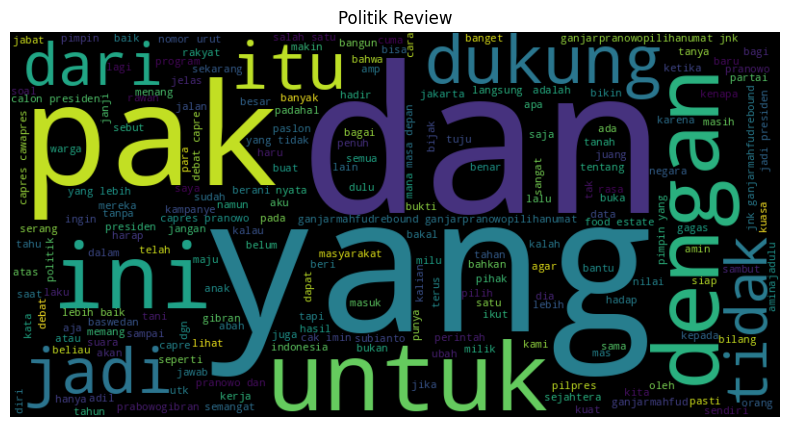

In [ ]:
politik = train[train['label']=="Politik"]['text'].tolist()
generate_wordcloud(politik,'Politik Review')

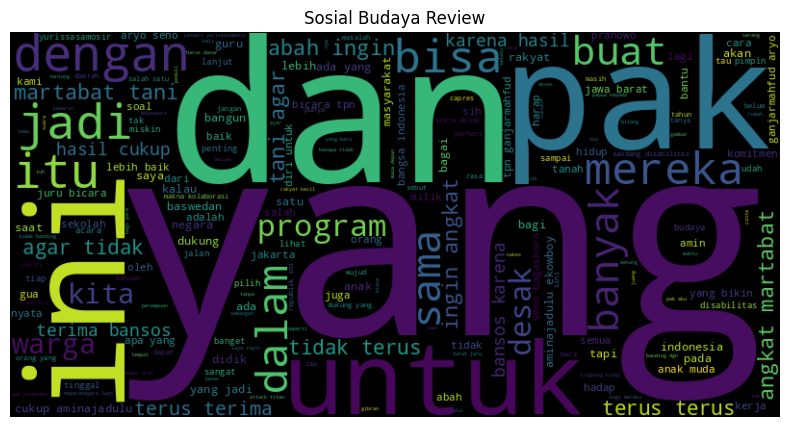

In [ ]:
sosBud = train[train['label']=="Sosial Budaya"]['text'].tolist()
generate_wordcloud(sosBud,'Sosial Budaya Review')

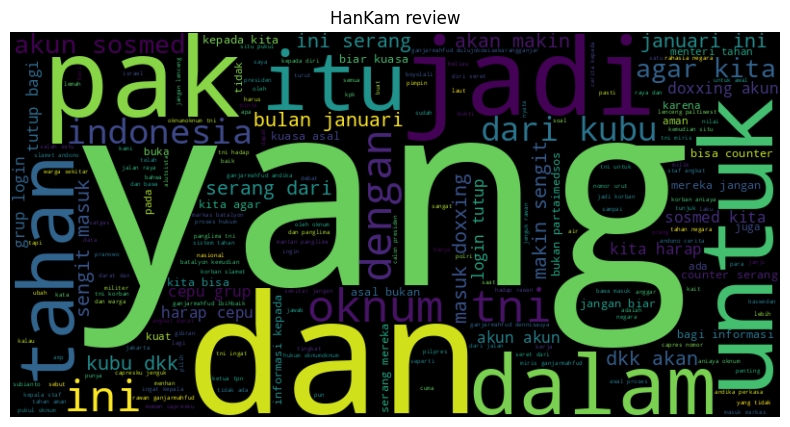

In [ ]:
hankam = train[train['label']=="Pertahanan dan Keamanan"]['text'].tolist()
generate_wordcloud(hankam,'HanKam review')

In [ ]:
ideologi = train[train['label']=="Ideologi"]['text'].tolist()
generate_wordcloud(ideologi,'Ideologi Review')

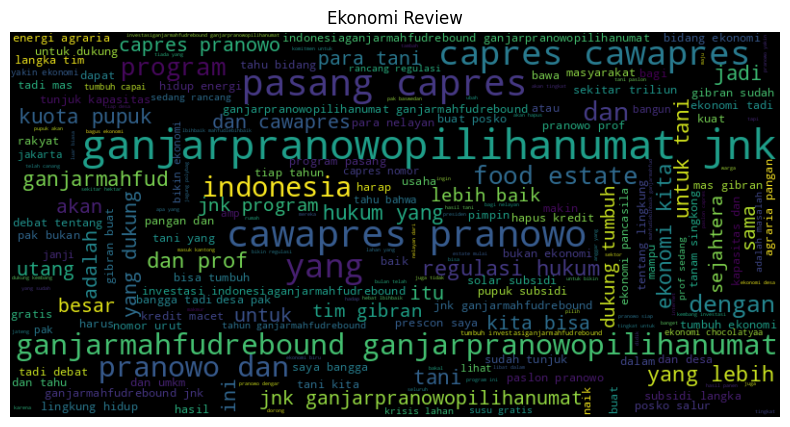

In [ ]:
ekonomi = train[train['label']=="Ekonomi"]['text'].tolist()
generate_wordcloud(ekonomi,'Ekonomi Review')

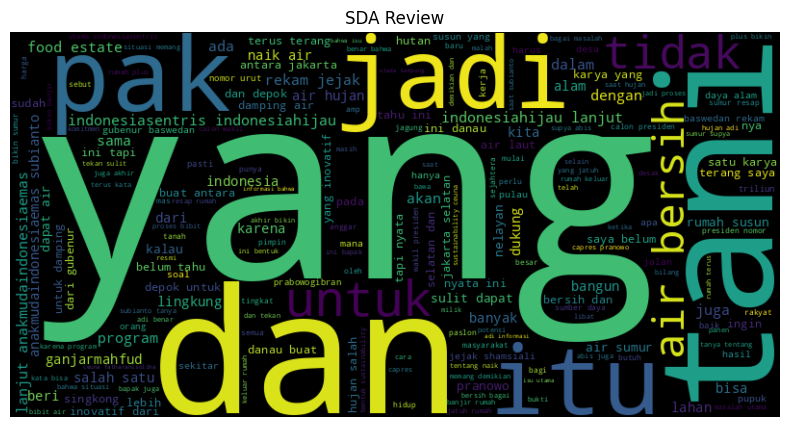

In [ ]:
sda = train[train['label']=="Sumber Daya Alam"]['text'].tolist()
generate_wordcloud(sda,'SDA Review')

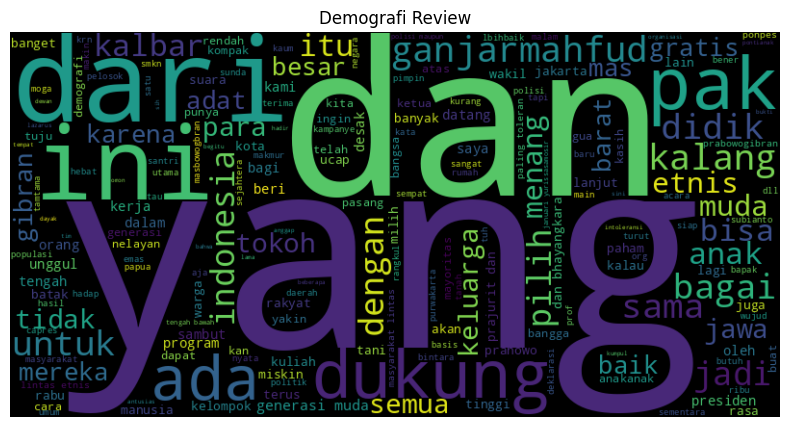

In [ ]:
Demografi = train[train['label']=="Demografi"]['text'].tolist()
generate_wordcloud(Demografi,'Demografi Review')

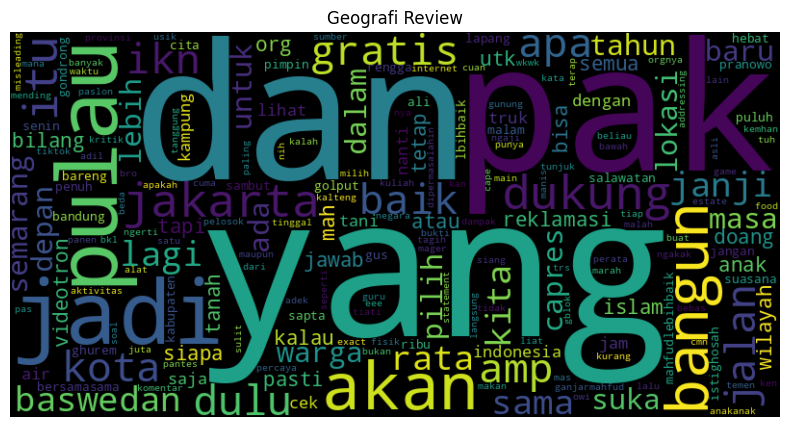

In [ ]:
geografi = train[train['label']=="Geografi"]['text'].tolist()
generate_wordcloud(geografi,'Geografi Review')

Ini coba coba buat table word count

In [ ]:
def tokenize(text):
    return text.split()

def word_count_by_classification(df, text_column, class_column):
    # Dictionary to hold word counts for each classification
    word_counts = {}

    for classification in df[class_column].unique():
        class_text = df[df[class_column] == classification][text_column].apply(preprocess_text)
        tokens = class_text.apply(tokenize)
        all_tokens = [token for sublist in tokens for token in sublist]
        word_counts[classification] = Counter(all_tokens)

    return word_counts

word_counts = word_count_by_classification(train, 'text', 'label')

In [ ]:
word_counts = word_count_by_classification(train, 'text', 'label')
print(word_counts)

{'Sumber Daya Alam': Counter({'yang': 146, 'dan': 112, 'air': 84, 'ini': 58, 'untuk': 55, 'tani': 52, 'jadi': 50, 'pak': 50, 'juga': 46, 'dengan': 42, 'itu': 42, 'rumah': 42, 'dari': 39, 'lanjut': 36, 'bisa': 31, 'dalam': 30, 'indonesiasentris': 29, 'tidak': 29, 'program': 28, 'jakarta': 26, 'bersih': 25, 'dapat': 25, 'indonesia': 25, 'indonesiahijau': 24, 'anakmudaindonesiaemas': 24, 'subianto': 24, 'hujan': 24, 'tentang': 23, 'alam': 23, 'karena': 23, 'sama': 22, 'food': 22, 'sumur': 22, 'estate': 21, 'masalah': 20, 'akan': 20, 'presiden': 20, 'ada': 20, 'tapi': 20, 'bangun': 19, 'salah': 19, 'ganjarmahfud': 19, 'baswedan': 19, 'terus': 19, 'rekam': 19, 'jejak': 19, 'saat': 18, 'bahwa': 18, 'pranowo': 18, 'naik': 17, 'dukung': 17, 'pupuk': 17, 'beri': 17, 'kita': 17, 'belum': 17, 'bikin': 17, 'saya': 17, 'calon': 16, 'nyata': 16, 'lingkung': 16, 'kerja': 16, 'susun': 16, 'mereka': 16, 'buat': 16, 'besar': 15, 'adalah': 15, 'banyak': 15, 'laut': 15, 'sulit': 14, 'utama': 14, 'milik': 

In [ ]:
word_count_df = pd.DataFrame.from_dict(word_counts, orient='index').fillna(0).astype(int)
word_count_df = word_count_df.transpose()

In [ ]:
print(word_count_df)


          Sumber Daya Alam  Politik  Demografi  Pertahanan dan Keamanan  \
kunjung                  8       29          1                        1   
ini                     58      676         22                      127   
untuk                   55      691         13                       85   
resmi                    6       21          0                        3   
dan                    112     1580         50                      203   
...                    ...      ...        ...                      ...   
longsor                  0        0          0                        0   
truk                     0        0          0                        0   
mayoitas                 0        0          0                        0   
yaaah                    0        0          0                        0   
sblum                    0        0          0                        0   

          Ideologi  Ekonomi  Sosial Budaya  Geografi  
kunjung          2        7              9  

In [ ]:
# Get unique values from the 'label' column
unique_labels = train['label'].unique()

# Convert the unique values to a list
unique_labels_list = unique_labels.tolist()

# Print the list of unique values
print(unique_labels_list)

['Sumber Daya Alam', 'Politik', 'Demografi', 'Pertahanan dan Keamanan', 'Ideologi', 'Ekonomi', 'Sosial Budaya', 'Geografi']


In [ ]:
label_dict = {}
for index, label in enumerate(unique_labels_list):
    label_dict[index] = label
print(label_dict)

{0: 'Sumber Daya Alam', 1: 'Politik', 2: 'Demografi', 3: 'Pertahanan dan Keamanan', 4: 'Ideologi', 5: 'Ekonomi', 6: 'Sosial Budaya', 7: 'Geografi'}


In [ ]:
train.head()

,text,label
0,kunjung ini untuk resmi dan serah proyek bantu...,Sumber Daya Alam
1,dapat tepuk tangan riah saat jadi rektor wajib...,Politik
2,emng bener sih dukung ada yang goblok begitu d...,Demografi
3,waktu sikap kritis kerja pak anggap engga sopa...,Politik
4,baswedan harap asn masuk tni dan polri pegang ...,Politik


In [ ]:
numpang =  {
    0: 'Sumber Daya Alam',
    1: 'Politik',
    2: 'Demografi',
    3: 'Pertahanan dan Keamanan',
    4: 'Ideologi',
    5: 'Ekonomi',
    6: 'Sosial Budaya',
    7: 'Geografi'
}

# Preprocess part 2

Remove Slang

In [ ]:
import pandas as pd
from indoNLP.preprocessing import replace_slang
train['text_removed_slang'] = train['text'].apply(replace_slang)
train.head()

,text,label,text_removed_slang
0,kunjung ini untuk resmi dan serah proyek bantu...,Sumber Daya Alam,kunjung ini untuk resmi dan serah proyek bantu...
1,dapat tepuk tangan riah saat jadi rektor wajib...,Politik,dapat tepuk tangan riah saat jadi rektor wajib...
2,emng bener sih dukung ada yang goblok begitu d...,Demografi,memang benar sih dukung ada yang goblok begitu...
3,waktu sikap kritis kerja pak anggap engga sopa...,Politik,waktu sikap kritis kerja pak anggap enggak sop...
4,baswedan harap asn masuk tni dan polri pegang ...,Politik,baswedan harap asn masuk tni dan polri pegang ...


remove elongated words

In [ ]:
train['text_cleaned'] = train['text_removed_slang'].apply(replace_word_elongation)
train.head()

,text,label,text_removed_slang,text_cleaned
0,kunjung ini untuk resmi dan serah proyek bantu...,Sumber Daya Alam,kunjung ini untuk resmi dan serah proyek bantu...,kunjung ini untuk resmi dan serah proyek bantu...
1,dapat tepuk tangan riah saat jadi rektor wajib...,Politik,dapat tepuk tangan riah saat jadi rektor wajib...,dapat tepuk tangan riah saat jadi rektor wajib...
2,emng bener sih dukung ada yang goblok begitu d...,Demografi,memang benar sih dukung ada yang goblok begitu...,memang benar sih dukung ada yang goblok begitu...
3,waktu sikap kritis kerja pak anggap engga sopa...,Politik,waktu sikap kritis kerja pak anggap enggak sop...,waktu sikap kritis kerja pak anggap enggak sop...
4,baswedan harap asn masuk tni dan polri pegang ...,Politik,baswedan harap asn masuk tni dan polri pegang ...,baswedan harap asn masuk tni dan polri pegang ...


In [ ]:
#from transformers import AutoTokenizer, AutoModelForSequenceClassification
#import torch
#wihu = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p2")
#wihu1 = 'indolem/indobert-base-uncased"'

In [ ]:
word_counts = word_count_by_classification(train, 'text_cleaned', 'label')
word_count_df = pd.DataFrame.from_dict(word_counts, orient='index').fillna(0).astype(int)
word_count_df = word_count_df.transpose()
print(word_counts)

{'Sumber Daya Alam': Counter({'yang': 146, 'dan': 112, 'air': 84, 'untuk': 67, 'ini': 58, 'tani': 52, 'jadi': 50, 'pak': 50, 'juga': 46, 'dengan': 44, 'itu': 42, 'rumah': 42, 'dari': 39, 'lanjut': 36, 'bisa': 32, 'dalam': 30, 'tidak': 30, 'indonesiasentris': 29, 'jakarta': 29, 'program': 28, 'dapat': 27, 'bersih': 25, 'indonesia': 25, 'indonesiahijau': 24, 'anakmudaindonesiaemas': 24, 'subianto': 24, 'hujan': 24, 'sama': 24, 'tentang': 23, 'alam': 23, 'sudah': 23, 'karena': 23, 'food': 22, 'sumur': 22, 'estate': 21, 'masalah': 20, 'akan': 20, 'presiden': 20, 'ada': 20, 'tapi': 20, 'terus': 20, 'bangun': 19, 'salah': 19, 'ganjarmahfud': 19, 'baswedan': 19, 'rekam': 19, 'jejak': 19, 'saat': 18, 'bahwa': 18, 'pranowo': 18, 'naik': 17, 'dukung': 17, 'pupuk': 17, 'beri': 17, 'kita': 17, 'belum': 17, 'mereka': 17, 'bikin': 17, 'saya': 17, 'calon': 16, 'nyata': 16, 'lingkung': 16, 'kerja': 16, 'susun': 16, 'banyak': 16, 'buat': 16, 'besar': 15, 'adalah': 15, 'laut': 15, 'sulit': 14, 'utama': 

# Model Building (udah cleaned and preprocess)

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import TFAutoModel
from tqdm.auto import tqdm
from transformers import BertTokenizer
import numpy as np

In [ ]:
# Load the IndoBERTweet tokenizer and model
tokenizer = BertTokenizer.from_pretrained("indolem/indobert-base-uncased")
model = TFAutoModel.from_pretrained("indolem/indobert-base-uncased", from_pt=True, num_labels=8)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/234k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predict

In [ ]:
train.head()

,text,label,text_removed_slang,text_cleaned
0,kunjung ini untuk resmi dan serah proyek bantu...,Sumber Daya Alam,kunjung ini untuk resmi dan serah proyek bantu...,kunjung ini untuk resmi dan serah proyek bantu...
1,dapat tepuk tangan riah saat jadi rektor wajib...,Politik,dapat tepuk tangan riah saat jadi rektor wajib...,dapat tepuk tangan riah saat jadi rektor wajib...
2,emng bener sih dukung ada yang goblok begitu d...,Demografi,memang benar sih dukung ada yang goblok begitu...,memang benar sih dukung ada yang goblok begitu...
3,waktu sikap kritis kerja pak anggap engga sopa...,Politik,waktu sikap kritis kerja pak anggap enggak sop...,waktu sikap kritis kerja pak anggap enggak sop...
4,baswedan harap asn masuk tni dan polri pegang ...,Politik,baswedan harap asn masuk tni dan polri pegang ...,baswedan harap asn masuk tni dan polri pegang ...


In [ ]:
token = tokenizer.encode_plus(
    train['text_cleaned'].iloc[0],
    max_length=256,
    truncation=True,
    padding='max_length',
    add_special_tokens=True,
    return_tensors='tf'
)

In [ ]:
token.input_ids

<tf.Tensor: shape=(1, 256), dtype=int32, numpy=
array([[    3, 11632,  1540,  1559,  3288,  1501, 21579,  3846,  2959,
         2039,  5174,  2715,  4021,  1718,  4926,  7174,  1718, 28481,
         1802,  4319,  1827, 10767,  1589, 15629,  1712,  6708, 24519,
            4,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0, 

In [ ]:
X_input_ids = np.zeros((len(train), 256))
X_attn_masks = np.zeros((len(train), 256))

In [ ]:
def generate_training_data(df, ids, masks, tokenizer):
    for i, text in tqdm(enumerate(df['text_cleaned'])):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=256,
            truncation=True,
            padding='max_length',
            add_special_tokens=True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized_text.input_ids
        masks[i, :] = tokenized_text.attention_mask
    return ids, masks

In [ ]:
X_input_ids, X_attn_masks = generate_training_data(train, X_input_ids, X_attn_masks, tokenizer)

0it [00:00, ?it/s]

In [ ]:
labels = np.zeros((len(train), 8))
labels.shape

(5000, 8)

In [ ]:
train_coba = pd.read_excel("/content/dataset_penyisihan_bdc_2024.xlsx")
train['label'] = train_coba['label']

<ipython-input-42-33900b2f3abf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['label'] = train_coba['label']


In [ ]:
label_map_reversed = {
    0: 'Sumber Daya Alam',
    1: 'Politik',
    2: 'Demografi',
    3: 'Pertahanan dan Keamanan',
    4: 'Ideologi',
    5: 'Ekonomi',
    6: 'Sosial Budaya',
    7: 'Geografi'
}
label_map = {v: k for k, v in label_map_reversed.items()}
train['label'] = train['label'].map(label_map)
train.head()

<ipython-input-43-5dfdedeaab80>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['label'] = train['label'].map(label_map)


,text_cleaned,label
0,kunjung ini untuk resmi dan serah proyek bantu...,0
1,dapat tepuk tangan riah saat jadi rektor wajib...,1
2,memang benar sih dukung ada yang goblok begitu...,2
3,waktu sikap kritis kerja pak anggap enggak sop...,1
4,baswedan harap asn masuk tni dan polri pegang ...,1


In [ ]:
label_counts = train['label'].value_counts()
print(label_counts)

label
1    2972
6     587
4     400
3     400
5     367
0     192
2      62
7      20
Name: count, dtype: int64


In [ ]:
labels[np.arange(len(train)), train['label'].values] = 1 # one-hot encoded target tensor


In [ ]:
labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attn_masks, labels))
dataset.take(1) # one sample data

<_TakeDataset element_spec=(TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(8,), dtype=tf.float64, name=None))>

In [ ]:
def SentimentDatasetMapFunction(input_ids, attn_masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': attn_masks
    }, labels

In [ ]:
dataset = dataset.map(SentimentDatasetMapFunction) # converting to required format for tensorflow dataset


In [ ]:
dataset.take(1)


<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(256,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(256,), dtype=tf.float64, name=None)}, TensorSpec(shape=(8,), dtype=tf.float64, name=None))>

In [ ]:
dataset = dataset.shuffle(10000).batch(16, drop_remainder=True) # batch size, drop any left out tensor

In [ ]:
dataset.take(1)


<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 256), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(16, 256), dtype=tf.float64, name=None)}, TensorSpec(shape=(16, 8), dtype=tf.float64, name=None))>

In [ ]:
p = 0.8
train_size = int((len(train)//16)*p)

In [ ]:
train_size

249

In [ ]:
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

In [ ]:
from transformers import TFBertModel

In [ ]:
model = TFBertModel.from_pretrained('indolem/indobert-base-uncased', from_pt=True) # bert base model with pretrained weights


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predict

In [ ]:
# defining 2 input layers for input_ids and attn_masks
input_ids = tf.keras.layers.Input(shape=(256,), name='input_ids', dtype='int32')
attn_masks = tf.keras.layers.Input(shape=(256,), name='attention_mask', dtype='int32')

bert_embds = model.bert(input_ids, attention_mask=attn_masks)[1] # 0 -> activation layer (3D), 1 -> pooled output layer (2D)
intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(bert_embds)
output_layer = tf.keras.layers.Dense(8, activation='softmax', name='output_layer')(intermediate_layer) # softmax -> calcs probs of classes

sentiment_model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)
sentiment_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 256)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 256)]                0         []                            
 )                                                                                                
                                                                                                  
 bert (TFBertMainLayer)      TFBaseModelOutputWithPooli   1105582   ['input_ids[0][0]',           
                             ngAndCrossAttentions(last_   08         'attention_mask[0][0]']      
                             hidden_state=(None, 256, 7                                       

In [ ]:
optim = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5, decay=1e-6)
loss_func = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

In [ ]:
sentiment_model.compile(optimizer=optim, loss=loss_func, metrics=[acc])


In [ ]:
hist = sentiment_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20
)

Epoch 1/20
249/249 [==============================] - 274s 899ms/step - loss: 1.3563 - accuracy: 0.5863 - val_loss: 1.2058 - val_accuracy: 0.6081
Epoch 2/20
249/249 [==============================] - 221s 886ms/step - loss: 1.1295 - accuracy: 0.6325 - val_loss: 0.9172 - val_accuracy: 0.7024
Epoch 3/20
249/249 [==============================] - 220s 884ms/step - loss: 0.8645 - accuracy: 0.7186 - val_loss: 0.7484 - val_accuracy: 0.7679
Epoch 4/20
249/249 [==============================] - 217s 871ms/step - loss: 0.7389 - accuracy: 0.7623 - val_loss: 0.5555 - val_accuracy: 0.8244
Epoch 5/20
249/249 [==============================] - 218s 874ms/step - loss: 0.6377 - accuracy: 0.8025 - val_loss: 0.4682 - val_accuracy: 0.8462
Epoch 6/20
249/249 [==============================] - 217s 873ms/step - loss: 0.5763 - accuracy: 0.8228 - val_loss: 0.4054 - val_accuracy: 0.8740
Epoch 7/20
249/249 [==============================] - 217s 873ms/step - loss: 0.5051 - accuracy: 0.8444 - val_loss: 0.3496 -

In [ ]:
sentiment_model.save('sentiment_model')

In [ ]:
!zip -r "/content/sentimen_model.zip" "/content/sentiment_model"

updating: content/sentiment_model/ (stored 0%)
updating: content/sentiment_model/fingerprint.pb (stored 0%)
updating: content/sentiment_model/keras_metadata.pb (deflated 95%)
updating: content/sentiment_model/variables/ (stored 0%)
updating: content/sentiment_model/variables/variables.data-00000-of-00001 (deflated 18%)
updating: content/sentiment_model/variables/variables.index (deflated 80%)
updating: content/sentiment_model/assets/ (stored 0%)
updating: content/sentiment_model/saved_model.pb (deflated 92%)


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Define the path to save the model in Google Drive
model_save_path = '/content/drive/My Drive/sentiment_model_1'

# Save the TensorFlow model to the specified path
sentiment_model.save(model_save_path)

Mounted at /content/drive


# Predict

In [ ]:
sentiment_model = tf.keras.models.load_model('sentiment_model')
tokenizer = BertTokenizer.from_pretrained("indolem/indobert-base-uncased")

def prepare_data(input_text, tokenizer):
    token = tokenizer.encode_plus(
        input_text,
        max_length=256,
        truncation=True,
        padding='max_length',
        add_special_tokens=True,
        return_tensors='tf'
    )
    return {
        'input_ids': tf.cast(token.input_ids, tf.float64),
        'attention_mask': tf.cast(token.attention_mask, tf.float64)
    }

def make_prediction(model, processed_data, classes=['Sumber Daya Alam', 'Politik', 'Demografi', 'Pertahanan dan Keamanan', 'Ideologi', 'Ekonomi', 'Sosial Budaya', 'Geografi']):
    probs = model.predict(processed_data)[0]
    return classes[np.argmax(probs)]

In [ ]:
input_text = input('Coba input: ')
processed_data = prepare_data(input_text, tokenizer)
result = make_prediction(sentiment_model, processed_data=processed_data)
print(f"Predicted Category: {result}")

Coba input: Lu mau org2 pro-demokrasi di negara ini bisa punya kesempatan lagi buat ngelawan oligarki di indo?
1/1 [==============================] - 0s 65ms/step
Predicted Category: Politik


# Preprocess Test Dataset and first prediction Submission

In [ ]:
test.head()

,IDText,Text
0,TXT0001,Lu mau org2 pro-demokrasi di negara ini bisa p...
1,TXT0002,Prabowo ditanya soal hutang luar negeri dia me...
2,TXT0003,kiki_daliyo Ganjar Pranowo itulah beliau soso...
3,TXT0004,@kumparan Prabowo Gibran yang bisa melakukan i...
4,TXT0005,@sniperruben45 @uda_zulhendra @ainunnajib Lah ...


In [ ]:
# Fungsi membersihkan email
def cleaning_email(data):
    return re.sub(r'@[^\s]+', ' ', data)

# Fungsi membersihkan URL
def cleaning_URLs(data):
    return re.sub(r'((www\.[^\s]+)|(https?://[^\s]+))', ' ', data)

# Fungsi membersihkan tanda baca
def cleaning_punctuations(text):
    return text.translate(str.maketrans('', '', string.punctuation))

# Fungsi membersihkan angka
def cleaning_numbers(data):
    return re.sub(r'[0-9]+', '', data)

# Fungsi menghapus karakter non-alfabet
def cleaning_non_alpha(text):
    return re.sub(r'[^a-z\s]', ' ', text)

# Lowercasing
def to_lowercase(data):
    return data.lower()

# Mengganti singkatan umum dalam bahasa Indonesia
def replace_slang(text):
    slang_dict = {
        "yg": "yang",
        "gak": "tidak",
        "nggak": "tidak",
        "kalo": "kalau",
        "mau": "ingin",
        # Tambahkan lebih banyak singkatan dan penggantinya sesuai kebutuhan
    }
    words = text.split()
    replaced_text = ' '.join([slang_dict[word] if word in slang_dict else word for word in words])
    return replaced_text

# Menggabungkan semua langkah preprocessing
def preprocess_text(text):
    text = to_lowercase(text)
    text = replace_slang(text)
    text = cleaning_email(text)
    text = cleaning_URLs(text)
    text = cleaning_punctuations(text)
    text = cleaning_numbers(text)
    text = cleaning_non_alpha(text)
    return text

# Terapkan preprocessing dasar ke setiap baris dalam kolom 'text'
test['Text'] = test['Text'].apply(preprocess_text)

# Dapatkan daftar stopwords bahasa Indonesia
stopwords_indonesia = stopwords.words('indonesian')
factory = StopWordRemoverFactory()
stopwords_sastrawi = factory.get_stop_words()
all_stopwords = set(stopwords_indonesia).union(set(stopwords_sastrawi))

# Buat stemmer untuk bahasa Indonesia
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Fungsi untuk membersihkan teks lebih lanjut
def final_clean_text(text):
    # Tokenisasi teks
    kata = word_tokenize(text)

    # Hapus stopwords
    #kata_tanpa_stopwords = [word for word in kata if not word in all_stopwords]

    # Stem kata
    kata_stemmed = [stemmer.stem(word) for word in kata]

    # Hapus kata-kata yang terlalu pendek (misal: satu huruf)
    kata_final = [word for word in kata_stemmed if len(word) > 2]

    # Gabungkan kembali kata-kata menjadi teks
    return " ".join(kata_final)

# Terapkan fungsi ke setiap baris dalam kolom 'text'
test['Text'] = test['Text'].apply(final_clean_text)

# Custom stopwords untuk kata-kata yang tidak diinginkan
custom_stopwords = {'rt', 'afja', 'jokowi', 'prabowo', 'ganjar', 'anies', 'mahfud', 'pilihan', 'umat', 'coblos', 're'}
def remove_custom_stopwords(text):
    words = word_tokenize(text)
    cleaned_words = [word for word in words if word not in custom_stopwords]
    return " ".join(cleaned_words)

# Terapkan custom stopwords removal
test['Text'] = test['Text'].apply(remove_custom_stopwords)

In [ ]:
test['text_removed_slang'] = test['Text'].apply(replace_slang)
test.head()

,IDText,Text,text_removed_slang
0,TXT0001,ingin org prodemokrasi negara ini bisa punya s...,ingin org prodemokrasi negara ini bisa punya s...
1,TXT0002,tanya soal hutang luar negeri dia jawab hutang...,tanya soal hutang luar negeri dia jawab hutang...
2,TXT0003,kikidaliyo pranowo itu beliau sosok yang menga...,kikidaliyo pranowo itu beliau sosok yang menga...
3,TXT0004,gibran yang bisa laku itu semua demi sejahtera...,gibran yang bisa laku itu semua demi sejahtera...
4,TXT0005,lah justru yang tidak nyambung junjung elu aom...,lah justru yang tidak nyambung junjung elu aom...


In [ ]:
test['text_cleaned'] = test['text_removed_slang'].apply(replace_word_elongation)
train.head()

,text_cleaned,label
0,kunjung ini untuk resmi dan serah proyek bantu...,0
1,dapat tepuk tangan riah saat jadi rektor wajib...,1
2,memang benar sih dukung ada yang goblok begitu...,2
3,waktu sikap kritis kerja pak anggap enggak sop...,1
4,baswedan harap asn masuk tni dan polri pegang ...,1


In [ ]:
test['prediction'] = ''

In [ ]:
for index, row in test.iterrows():
    input_text = row['text_cleaned']
    processed_data = prepare_data(input_text, tokenizer)
    prediction = make_prediction(sentiment_model, processed_data)
    test.at[index, 'Prediction'] = prediction

# Save the DataFrame with predictions to a new CSV file
test.to_csv('test_with_predictions.csv', index=False)

1/1 [==============================] - 0s 94ms/step


In [ ]:
test.head()

,IDText,Text,text_removed_slang,text_cleaned,prediction,Prediction
0,TXT0001,ingin org prodemokrasi negara ini bisa punya s...,ingin org prodemokrasi negara ini bisa punya s...,ingin org prodemokrasi negara ini bisa punya s...,,Politik
1,TXT0002,tanya soal hutang luar negeri dia jawab hutang...,tanya soal hutang luar negeri dia jawab hutang...,tanya soal hutang luar negeri dia jawab hutang...,,Politik
2,TXT0003,kikidaliyo pranowo itu beliau sosok yang menga...,kikidaliyo pranowo itu beliau sosok yang menga...,kikidaliyo pranowo itu beliau sosok yang menga...,,Ideologi
3,TXT0004,gibran yang bisa laku itu semua demi sejahtera...,gibran yang bisa laku itu semua demi sejahtera...,gibran yang bisa laku itu semua demi sejahtera...,,Politik
4,TXT0005,lah justru yang tidak nyambung junjung elu aom...,lah justru yang tidak nyambung junjung elu aom...,lah justru yang tidak nyambung junjung elu aom...,,Politik


In [ ]:
# Define the path to save the DataFrame with predictions in Google Drive
output_path = '/content/drive/My Drive/test_with_predictions.csv'

# Save the DataFrame with predictions to a new CSV file in Google Drive
test.to_csv(output_path, index=False)

In [ ]:
submission = test[['IDText', 'Prediction']]
submission = submission.rename(columns={'Prediction': 'Kelas'})
submission.head()

,IDText,Kelas
0,TXT0001,Politik
1,TXT0002,Politik
2,TXT0003,Ideologi
3,TXT0004,Politik
4,TXT0005,Politik


In [ ]:
kelas_counts = submission['Kelas'].value_counts()
print(kelas_counts)

Kelas
Politik                    728
Ekonomi                    132
Pertahanan dan Keamanan     58
Sosial Budaya               42
Ideologi                    21
Sumber Daya Alam            14
Geografi                     4
Demografi                    1
Name: count, dtype: int64


In [ ]:
submission.to_csv('Submission_Format.csv', index=False)

In [ ]:
# Define the path to save the DataFrame with predictions in Google Drive
output_path = '/content/drive/My Drive/Submission_Format.csv'

# Save the DataFrame with predictions to a new CSV file in Google Drive
submission.to_csv(output_path, index=False)